# Dummy Dataset

Here we define the dummy DEM and some dummy inundation maps. Note that the inundation maps match lower areas in the DEM, plus some random noise, in order to be closer to realistic scenarios. 

In [10]:
from typing import Optional, Sequence, Tuple
from matplotlib import pyplot as plt
import numpy as np
import dataclasses


# Stores the ground truth image with the corresponding gauge measurement.
@dataclasses.dataclass
class GroundTruthMeasurement:
  # The ground truth inundation map.
  ground_truth: np.ma.MaskedArray
  # The corresponding gauge measurement.
  gauge_measurement: float

### Create the dummy DEM

In [11]:
# DEM = np.tile(np.abs(np.arange(-16, 16, step=0.25)), (128, 1)) + 100
# DEM = DEM - np.tile(np.arange(10, 0, step=-10/128), (128, 1)).T
# DEM[32:64, 100:120] -= 10
# plt.imshow(DEM)
# plt.colorbar()

## Create the dummy inundation maps

In [12]:
def river_with_length(length):
    first_row = np.zeros(128)
    first_row[64-length:64+length] = True
    imap = np.tile(first_row, (128, 1)).astype(bool)

    random_mask = np.random.rand(128, 128) > 0.95
    imap ^= random_mask 
    return np.ma.masked_array(imap)

GROUND_TRUTH = [
    GroundTruthMeasurement(
        ground_truth=river_with_length(3),
        gauge_measurement=1
    ),
    GroundTruthMeasurement(
        ground_truth=river_with_length(10),
            gauge_measurement=2
    ),
    GroundTruthMeasurement(
        ground_truth=river_with_length(20),
        gauge_measurement=3
    )
]

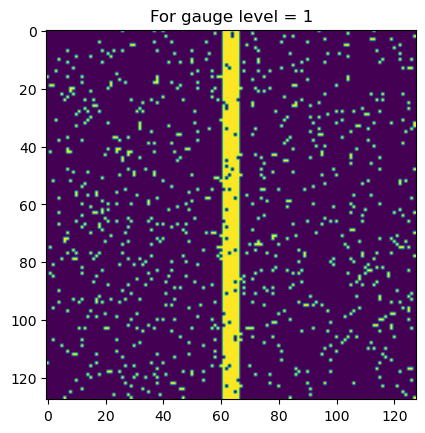

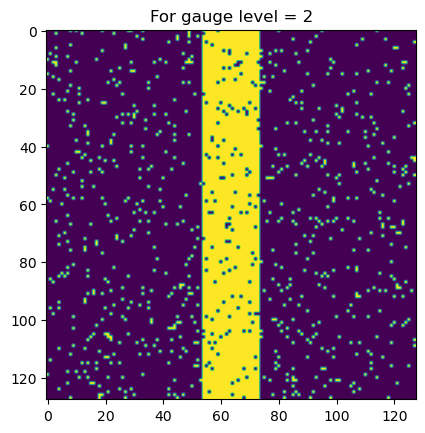

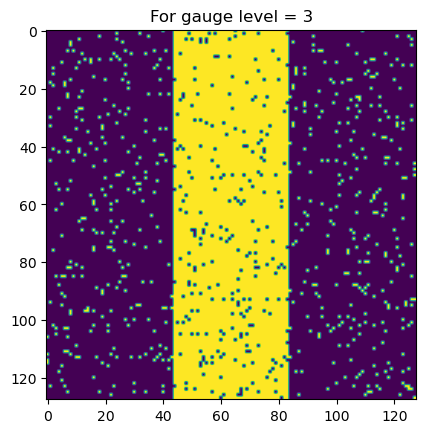

In [13]:
for gt in GROUND_TRUTH:
    plt.imshow(gt.ground_truth)
    plt.title(f'For gauge level = {gt.gauge_measurement}')
    plt.show()

# Thresholding Model

Below is the code for the *Thresholding model* as described in the paper.

## Thresholding model code

In [14]:
# pip install absl-py

In [15]:
"""Library functions for predicting flood extent based on historical data."""
from typing import Optional, Sequence, Tuple

from absl import logging
import numpy as np

# Range above heighest measurement and below lowest measurement in which we expect to get measurements.
_MEASUREMENT_BUFFER_METERS = 10

# A number that is smaller than the uncertainty bound of a gauge measurement.
_EPSILON = 0.002


def get_cutoff_points(
    measurements: np.ndarray,
    precision_oriented: bool) -> Tuple[Sequence[int], np.ndarray]:
  """Gets all valid cutoff points and threshold values.

  A cutoff point is the index of a measurement at which we can separate lower
  measurements from higher measurements. For a cutoff point i, the matching
  threshold value must be greater or equal to measurement[i-1] and less than
  measurement[i]. Thus, the i'th event is the first wet event.

  The corresponding threshold value is a gauge measurement value which separates
  examples up to the given cutoff from those above the given cutoff.

  Args:
    measurements: All obtained measurements in the training set, sorted in
      ascending order.
    precision_oriented: if true, select the i'th cutoff to be measurements[i] -
      _EPSILON, otherwise the i'th cutoff is measurements[i-1]

  Raises:
    ValueError: If measurements are not sorted.

  Returns:
    cutoff_points: Indices at which there exists a threshold which separates
      between positive and negative measurements. The length of the list is the
      number of distinct measurements plus 1.
    threshold_values: Gauge measurement values which separate at those cutoffs.
      Shape is (num_cutoffs,).
  """
  # `measurements` is sorted in ascending order. Let's just verify this.
  if np.any(np.diff(measurements) < 0):
    raise ValueError('Expected measurements to be sorted: %r' % measurements)

  # Add an artificially low threshold value, to be used for pixels which should
  # always be wet.
  threshold_values = [measurements[0] - _MEASUREMENT_BUFFER_METERS]
  cutoff_points = [0]

  differing_measurements = ~np.isclose(measurements[:-1], measurements[1:])
  differing_locations = np.nonzero(differing_measurements)[0]
  cutoff_points.extend(differing_locations + 1)
  # For cutoffs higher than the lowest event and lower than the highest event,
  # any threshold value between measurements[i] and measurements[i+1] can be
  # used.
  if precision_oriented:
    # To be as conservative as possible, we choose measurements[i+1] - _EPSILON,
    # in order to include as small a region as possible in the risk map.
    threshold_values.extend(measurements[differing_locations + 1] - _EPSILON)
  else:
    # To alert as much as possible, we choose measurements[i],
    # in order to include as large a region as possible in the risk map.
    threshold_values.extend(measurements[differing_locations])

  # Add the final threshold. When not precision oriented, above the highest
  # event all pixels should be considered inundated. When precision oriented,
  # above the inundation map should be equal to that of the highest event.
  threshold_values.append(measurements[-1])
  if precision_oriented:
    threshold_values[-1] += _MEASUREMENT_BUFFER_METERS
  cutoff_points.append(len(measurements))

  logging.info('Found %d threshold values: %r', len(threshold_values),
               np.asarray(threshold_values))

  return cutoff_points, np.asarray(threshold_values, dtype=np.float)


def _count_true_in_suffixes(imaps: np.ndarray,
                            cutoff_points: Sequence[int]) -> np.ndarray:
  """Returns the number of True's above the cutoff at each pixel.

  Args:
    imaps: Observed inundation maps for all training set flood events, sorted by
      increasing gauge measurement. Shape is (num_train_examples,height,width)
      for 3d arrays, or (num_train_examples,) for 1d arrays.
    cutoff_points: Indices into the first axis of `imaps`, at which it is
      possible to separate between lower and higher flood events. This includes
      all indices except those having identical gauge measurements as the
      subsequent event.

  Returns:
    Array with the same shape as imaps, where the first axis has shape
    num_cutoffs instead of num_train_examples. For example, if imaps is an array
    with shape (num_train_examples, height, width), the result is an array with
    shape (num_cutoffs, height, width) whose [c,i,j] element is the number of
    events whose pixel [i,j] is True above cutoff c.
  """
  all_count_true = np.nancumsum(imaps[::-1], axis=0)[::-1]
  # If the suffix is empty, the number of True's is zero.
  filler_zeros = np.expand_dims(np.zeros_like(all_count_true[0]), 0)
  all_count_true = np.concatenate([all_count_true, filler_zeros])
  return all_count_true.take(cutoff_points, axis=0, mode='clip')


def count_true_wets_per_cutoff(imaps: np.ndarray,
                               cutoff_points: Sequence[int]) -> np.ndarray:
  """Returns the number of wets observations of each pixel above each cutoff.

  Wet observations of a pixel above a given cutoff can be thought of as "true
  wet" decisions for that cutoff value.

  Args:
    imaps: Observed inundation maps for all training set flood events, sorted by
      increasing gauge measurement. Shape is (num_train_examples,height,width)
      for 3d arrays, or (num_train_examples,) for 1d arrays.
    cutoff_points: Indices into the first axis of `imaps`, at which it is
      possible to separate between lower and higher flood events. This includes
      all indices except those having identical gauge measurements as the
      subsequent event.

  Returns:
    Array with the same shape as imaps, where the first axis has shape
    num_cutoffs instead of num_train_examples. For example, if imaps is an array
    with shape (num_train_examples, height, width), the result is an array with
    shape (num_cutoffs, height, width) whose [c,i,j] element is the number of
    events whose pixel [i,j] is wet above cutoff c.
  """
  return _count_true_in_suffixes(imaps, cutoff_points)


def count_false_wets_per_cutoff(imaps: np.ndarray,
                                cutoff_points: Sequence[int]) -> np.ndarray:
  """Returns the number of dry observations of each pixel above each cutoff.

  Dry observations of a pixel above a given cutoff can be thought of as "false
  wet" decisions for that cutoff value.

  Args:
    imaps: Observed inundation maps for all training set flood events, sorted by
      increasing gauge measurement. Shape is (num_train_examples,height,width)
      for 3d arrays, or (num_train_examples,) for 1d arrays.
    cutoff_points: Indices into the first axis of `imaps`, at which it is
      possible to separate between lower and higher flood events. This includes
      all indices except those having identical gauge measurements as the
      subsequent event.

  Returns:
    Array with the same shape as imaps, where the first axis has shape
    num_cutoffs instead of num_train_examples. For example, if imaps is an array
    with shape (num_train_examples, height, width), the result is an array with
    shape (num_cutoffs, height, width) whose [c,i,j] element is the number of
    events whose pixel [i,j] is wet below cutoff c.
  """
  not_imaps = 1 - imaps
  return _count_true_in_suffixes(not_imaps, cutoff_points)


def count_false_drys_per_cutoff(imaps: np.ndarray,
                                cutoff_points: Sequence[int]) -> np.ndarray:
  """Returns the number of wet observations of each pixel below each cutoff.

  Wet observations of a pixel below a given cutoff can be thought of as "false
  dry" decisions for that cutoff value.

  Args:
    imaps: Observed inundation maps for all training set flood events, sorted by
      increasing gauge measurement. Shape is (num_train_examples,height,width)
      for 3d arrays, or (num_train_examples,) for 1d arrays.
    cutoff_points: Indices into the first axis of `imaps`, at which it is
      possible to separate between lower and higher flood events. This includes
      all indices except those having identical gauge measurements as the
      subsequent event.

  Returns:
    Array with the same shape as imaps, where the first axis has shape
    num_cutoffs instead of num_train_examples .For example, if imaps is an array
    with shape (num_train_examples, height, width), the result is an array with
    shape (num_cutoffs, height, width) whose [c,i,j] element is the number of
    events whose pixel [i,j] is dry above cutoff c.
  """
  all_count_false_drys = np.nancumsum(imaps, axis=0)
  # If the cutoff is lower than all events, the number of false drys is zero.
  filler_zeros = np.expand_dims(np.zeros_like(all_count_false_drys[0]), 0)
  all_count_false_drys = np.concatenate([filler_zeros, all_count_false_drys])
  return all_count_false_drys.take(cutoff_points, axis=0, mode='clip')


def _get_pixel_threshold_index(pixel_events: np.ndarray,
                               cutoff_points: np.ndarray,
                               min_ratio: float) -> int:
  """Calculates the threshold index in cutoff_points for a single pixel.

  Args:
    pixel_events: 1D array of the inundation at the pixel for all events, by
      increasing gauge order.
    cutoff_points: Indices into the first axis of `imaps`, at which it is
      possible to separate between lower and higher flood events. This includes
      all indices except those having identical gauge measurements as the
      subsequent event.
    min_ratio: Select the threshold at each pixel such that the ratio between
      added true positives and added false positives is above min_ratio.

  Returns:
    Index within cutoff_points of the threshold of the given pixel.
  """
  while np.nansum(pixel_events):
    true_wets = count_true_wets_per_cutoff(pixel_events, cutoff_points)
    false_wets = count_false_wets_per_cutoff(pixel_events, cutoff_points)
    ratios = true_wets / false_wets
    # The empty slice, corresponding to ratios[-1], has 0 true wets and 0 false
    # wets. We define the ratio there to be 0, as we want any slice that
    # contain a true wet to have a higher ratio than the empty slice.
    ratios[-1] = 0
    # Take the last maximum. In the case we have d, nan, w, we want the
    # threshold to be between nan and w, despite the fact that the threshold
    # between d and nan has the same ratio.
    best_index = ratios.shape[0] - 1 - np.nanargmax(ratios[::-1])

    if ratios[best_index] < min_ratio:
      break
    # Find the next candidate threshold on the prefix of all events below the
    # current best cutoff point.
    best_cutoff_point = cutoff_points[best_index]
    pixel_events = pixel_events[:best_cutoff_point]
    cutoff_points = cutoff_points[:best_index + 1]
  # If the remaining slice contains only NaNs, pixel should always be
  # inundated.
  if np.all(np.isnan(pixel_events)):
    return 0
  return len(cutoff_points) - 1


def _get_threshold_indices(imaps: np.ndarray, cutoff_points: np.ndarray,
                           min_ratio: float) -> np.ndarray:
  """Calculates the threshold index in cutoff_points for all pixels.

  Args:
    imaps: Observed inundation maps for all training set flood events, sorted by
      increasing gauge measurement. Shape is (num_train_examples,height,width).
    cutoff_points: Indices into the first axis of `imaps`, at which it is
      possible to separate between lower and higher flood events. This includes
      all indices except those having identical gauge measurements as the
      subsequent event.
    min_ratio: Select the threshold at each pixel such that the ratio between
      added true positives and added false positives is above min_ratio.

  Returns:
    threshold_indices: Array of threshold indices within cutoff_points for
      each pixel. Shape is (height, width).
  """
  threshold_indices = np.zeros_like(imaps[0, :, :], dtype=int)
  for idx_y in range(threshold_indices.shape[0]):
    for idx_x in range(threshold_indices.shape[1]):
      threshold_indices[idx_y, idx_x] = _get_pixel_threshold_index(
          imaps[:, idx_y, idx_x], cutoff_points, min_ratio)
  return threshold_indices


def _learn_optimal_sar_prediction_internal(imaps: np.ndarray,
                                           measurements: np.ndarray,
                                           min_ratio: float) -> np.ndarray:
  """A version of learn_sar_prediction without the external data structures.

  Selects the threshold such that the number of added true positives divided by
  the number of added false positives is at least min_ratio.

  Args:
    imaps: Observed inundation maps for all training set flood events, sorted by
      increasing gauge measurement. Shape is (num_train_examples,height,width).
    measurements: All obtained measurements in the training set, sorted in
      ascending order.
    min_ratio: Selects the threshold at each pixel such that the ratio between
      added true positives and added false positives is above min_ratio.

  Returns:
    Array of thresholds for each pixel. Shape is (height, width).
  """
  cutoff_points, threshold_values = get_cutoff_points(
      measurements, precision_oriented=True)

  threshold_indices = _get_threshold_indices(imaps, np.array(cutoff_points),
                                             min_ratio)
  thresholds = threshold_values[threshold_indices]

  if np.issubdtype(imaps.dtype, np.floating):
    # If all inundation maps are NaN for a given pixel, make the threshold for
    # that pixel a NaN as well. This occurs when the pixel is outside the
    # requested forecast_region.
    thresholds = np.where(np.all(np.isnan(imaps), axis=0), np.nan, thresholds)

  return thresholds


def masked_array_to_float_array(masked_array):
  float_array = np.array(masked_array, dtype=float)
  mask = np.ma.getmaskarray(masked_array)
  float_array[mask] = np.nan
  return float_array


def learn_optimal_sar_prediction_from_ground_truth(
    flood_events_train: Sequence[GroundTruthMeasurement],
    min_ratio: Optional[float] = None) -> np.ndarray:
  """Constructs a GaugeThresholdingModel based on historical observations.

  This finds the optimal thresholding model for a specific min ratio, as
  described in the paper.

  Args:
    flood_events_train: Sequence of GroundTruthMeasurement objects to be used
      as training set.
    min_ratio: float argument. If provided, selects the threshold at each pixel
      such that the ratio between added true positives and added false positives
      is above min_ratio.

  Returns:
    GaugeThresholdingModel proto containing the learned model. For the optimal
    thresholding model only one threshold is learned, so the high, medium and
    low risk thresholds of the model are identical.
  """

  # shape=(num_train_examples, height, width)
  imaps = np.asarray([
      masked_array_to_float_array(fe.ground_truth) for fe in flood_events_train
  ])

  # shape=(num_train_examples,)
  measurements = np.asarray(
      [fe.gauge_measurement for fe in flood_events_train])
  return _learn_optimal_sar_prediction_internal(imaps, measurements,
                                                      min_ratio)

### Optimal min_ratio code

In [16]:
MIN_RATIOS = [0.1, 0.3, 0.5, 1, 2, 5, 10, 15, 20]

class ThresholdingModel:

    def f1_metric(self, ground_truths: Sequence[GroundTruthMeasurement],
                  thresholds: np.ndarray) -> float:
        """Returns the aggregated F1 metric for a set of thresholds."""
        relevant_true = predicted_true = true_positives = 0
        for gt in ground_truths:
            predicted = thresholds < gt.gauge_measurement
            actual = gt.ground_truth.astype(bool)
            true_positives += np.sum(predicted & actual)
            predicted_true += np.sum(predicted)
            relevant_true += np.sum(actual)
        
        total_precision = true_positives / predicted_true
        total_recall = true_positives / relevant_true
        return 2/(1/total_precision + 1/total_recall)

    def train(self, ground_truth: Sequence[GroundTruthMeasurement]):
        """Trains the model according to the provided training set."""
        min_ratio_to_thresholds = {}
        f1_to_min_ratio = {}
        for min_ratio in MIN_RATIOS:
            min_ratio_to_thresholds[min_ratio] = (
                learn_optimal_sar_prediction_from_ground_truth(GROUND_TRUTH, 
                                                               min_ratio))
            f1 = self.f1_metric(ground_truth, 
                                min_ratio_to_thresholds[min_ratio])
            print(f'For min_ratio={min_ratio} we get f1={f1}')
            f1_to_min_ratio[f1] = min_ratio
        
        best_f1 = max(f1_to_min_ratio.keys())
        best_min_ratio = f1_to_min_ratio[best_f1]
        print('chosen min_ratio', best_min_ratio)
        self.thresholds = min_ratio_to_thresholds[best_min_ratio]
    
    def infer(self, gauge_level: float):
        """Returns the inferred inundation model for a gauge level."""
        return self.thresholds < gauge_level

## Test code with dummy dataset

In [17]:
#@title train over dummy dataset
tm = ThresholdingModel()
tm.train(GROUND_TRUTH)

/var/folders/_s/v895zwy14cl5h2nzfq54qq500000gn/T/ipykernel_34656/3864856466.py:78: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return cutoff_points, np.asarray(threshold_values, dtype=np.float)
/var/folders/_s/v895zwy14cl5h2nzfq54qq500000gn/T/ipykernel_34656/3864856466.py:212: RuntimeWarning: invalid value encountered in divide
  ratios = true_wets / false_wets
/var/folders/_s/v895zwy14cl5h2nzfq54qq500000gn/T/ipykernel_34656/3864856466.py:212: RuntimeWarning: divide by zero encountered in divide
  ratios = true_wets / false_wets


For min_ratio=0.1 we get f1=0.9133729636520397
For min_ratio=0.3 we get f1=0.9133729636520397
For min_ratio=0.5 we get f1=0.9133729636520397
For min_ratio=1 we get f1=0.9327525450274079
For min_ratio=2 we get f1=0.9271705713982826
For min_ratio=5 we get f1=0.9235212322173495
For min_ratio=10 we get f1=0.9235212322173495
For min_ratio=15 we get f1=0.9235212322173495
For min_ratio=20 we get f1=0.9235212322173495
chosen min_ratio 1


### Inference examples

The thresholding model has been trained on three inundation maps, corresponding to gauge levels of 1, 2 and 3. Below, one can see that the output for gauge levels of 2, 2.5, and 3.

It can be seen that for 1 and 1.5, the image is less noisy. This is due to the monotinization that is done by the model, since the model does not allow for a decrease in flood where the gauge level rises.

It can also be seen that the model is not able to interpolate between the images in the train set, as expected.

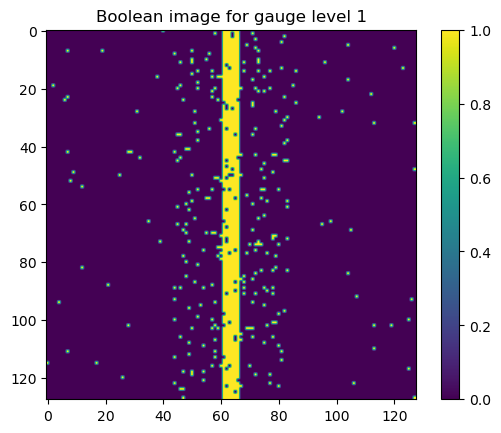

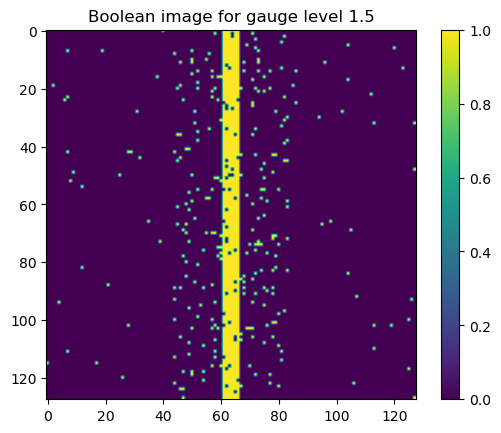

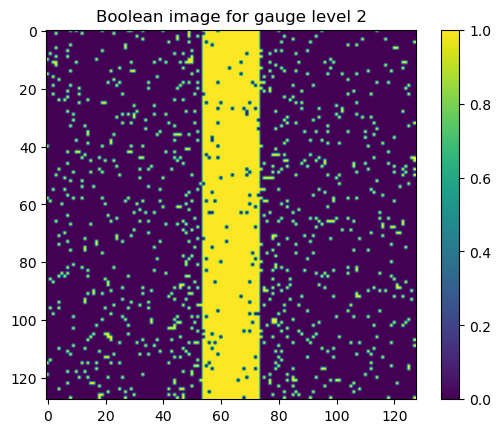

In [19]:
for gauge_level in [1, 1.5, 2]:
    plt.title(f'Boolean image for gauge level {gauge_level}')
    plt.imshow(tm.infer(gauge_level))
    plt.colorbar()
    plt.show()